# Analyze template coadds for Run2.1i

In [1]:
import os
import sys
import numpy as np

In [2]:
import pandas as pd

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [4]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
from lsst.daf.persistence import Butler
from lsst.geom import SpherePoint
import lsst.geom

In [5]:
# Requires issues/337 to fix obshistid query.
sys.path.insert(0, '/global/homes/b/bos0109/desc/gcr-catalogs')

In [6]:
import GCRCatalogs

In [7]:
#%matplotlib inline

#import matplotlib.pyplot as plt
import ipympl
%matplotlib notebook
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
#from matplotlib.patches import Polygon

In [8]:
sys.path.insert(0, '/global/homes/b/bos0109/run2_diaproc/')
import dm_utilities as dmu

import importlib
importlib.reload(dmu)

<module 'dm_utilities' from '/global/homes/b/bos0109/run2_diaproc/dm_utilities.py'>

### Load all catalogs for t+p 4431 (1, 5)

In [9]:
diarepo = '/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/rerun/assoc_sha/rerun/forcedPhot'
tmprepo = '/global/cscratch1/sd/bos0109/templates_rect/rerun/multiband'
#repo = '/global/cscratch1/sd/bos0109/templates_004/rerun/multiband'

In [16]:
butler = Butler(tmprepo)

In [17]:
tract = 4431
patch = (1, 5)

In [18]:
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[tract]

In [19]:
tract_info

TractInfo(id=4431, ctrCoord=[0.47856804252908186, 0.7002981175366394, -0.5296745937313986])

In [20]:
tract_patch_box = tract_info.getPatchInfo(patch).getOuterBBox()
tract_patch_pos_list = tract_patch_box.getCorners()
# Cast to Point2D, because pixelToSky below will refuse to work with a Point2I object.
tract_patch_pos_list = [afwGeom.Point2D(tp) for tp in tract_patch_pos_list]

wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_patch_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [21]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [22]:
max_ra = 58
min_ra = 56
max_dec = -31
min_dec = -32

In [23]:
print(min_ra, max_ra, min_dec, max_dec)

56 58 -32 -31


What is the approximated area of this polygon?

In [24]:
delta_ra, delta_dec = max_ra-min_ra, max_dec-min_dec

In [25]:
area = np.cos(np.deg2rad(min_dec+delta_dec*0.5))*np.deg2rad(delta_ra)*np.deg2rad(delta_dec)*180.*180./(np.pi**2.)*u.deg*u.deg

In [26]:
print(area, ',', area.to(u.arcmin**2))

1.7052803287081841 deg2 , 6139.0091833494635 arcmin2


In [27]:
print((delta_ra*u.deg).to(u.arcmin), (delta_dec*u.deg).to(u.arcmin))

120.0 arcmin 60.0 arcmin


Now we have done exactly the same stuff as in other notebooks but for our templates

### Exploring corners and t+p positions

Center

In [28]:
dmu.get_coadd_id_for_ra_dec(skymap, min_ra+delta_ra/2., min_dec+delta_dec/2.)

{'tract': 4432, 'patch': '5,5'}

Corners

In [29]:
dmu.get_coadd_id_for_ra_dec(skymap, min_ra, min_dec)

{'tract': 4431, 'patch': '2,3'}

In [30]:
dmu.get_coadd_id_for_ra_dec(skymap, min_ra, max_dec)

{'tract': 4639, 'patch': '4,1'}

In [31]:
dmu.get_coadd_id_for_ra_dec(skymap, max_ra, min_dec)

{'tract': 4432, 'patch': '1,3'}

In [32]:
dmu.get_coadd_id_for_ra_dec(skymap, max_ra, max_dec)

{'tract': 4640, 'patch': '3,1'}

Questions for this set of templates:
* Which visits were coadded in each filter?
* Which is the limiting magnitude for each template?
* Which is the seeing for each template?

In [33]:
#tpId = {'tract': 4640, 'patch': '6,0'}
tpId = {'tract': 4431, 'patch': '1,5'}

In [34]:
coaddMapper = butler._getDefaultMapper()

In [35]:
mapper = coaddMapper(root=tmprepo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

In [36]:
ls /global/cscratch1/sd/bos0109/templates_004/rerun/multiband/deepCoadd-results/

g/  i/  merged/  r/  u/  y/  z/


In [37]:
cat /global/cscratch1/sd/bos0109/templates_004/rerun/multiband/repositoryCfg.yaml

!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.lsst.imsim.ImsimMapper ''
_mapperArgs: {}
_parents:
- ../..
_policy: null
_root: null
dirty: true


In [38]:
butler.getKeys('deepCoadd_calexp')

{'filter': str, 'tract': int, 'patch': str}

In [39]:
tpId

{'tract': 4431, 'patch': '1,5'}

In [40]:
#tpId = {'tract': 4432, 'patch': '(0, 0)'}

In [41]:
cvi = butler.queryMetadata('calexp', ['id', 'visit', 'filter'], dataId=tpId)

In [42]:
butler.datasetExists('calexp', dataId=tpId)

False

In [43]:
merged_sources = butler.get('deepCoadd_mergeDet', dataId=tpId).asAstropy()

In [44]:
merged_sources.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'merge_footprint_i',
 'merge_footprint_r',
 'merge_footprint_z',
 'merge_footprint_y',
 'merge_footprint_g',
 'merge_footprint_u',
 'merge_footprint_sky']

## Inspecting the SNe that fall in this Patch

In [45]:
sntab = pd.read_csv('../catalogs+tables/supernovae_cat_2_sq_deg.csv')

In [46]:
len(sntab)

2138

In [47]:
sntab.columns

Index(['Unnamed: 0', 'htmid_level_6', 'galaxy_id', 'c_in', 'mB', 't0_in',
       'x0_in', 'x1_in', 'z_in', 'snid_in', 'snra_in', 'sndec_in'],
      dtype='object')

In [48]:
sntab = sntab.query("snra_in > {} and snra_in < {} and sndec_in > {} and sndec_in < {}".format(min_ra, max_ra, min_dec, max_dec))

In [49]:
len(sntab)

2138

Text(0, 0.5, '$\\delta$')

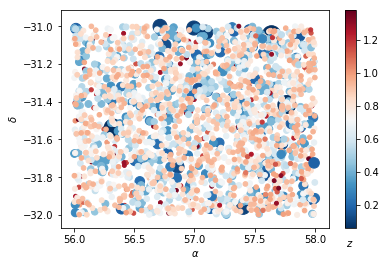

In [50]:
plt.scatter(sntab.snra_in, sntab.sndec_in, s=20/sntab.z_in, c=sntab.z_in, cmap='RdBu_r')

clb = plt.colorbar()
clb.set_label(r'$z$', labelpad=-30, y=-0.05, rotation=0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

In [51]:
from astropy import time

In [52]:
t0 = time.Time(sntab.t0_in, format='mjd', scale='utc')

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


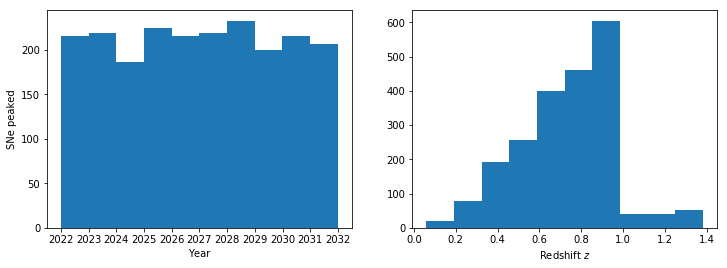

In [53]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(t0.datetime64, cumulative=False)
plt.xlabel('Year')
plt.ylabel('SNe peaked')

plt.subplot(122)
plt.hist(sntab.z_in, cumulative=False)
plt.xlabel(r'Redshift $z$')
plt.show()

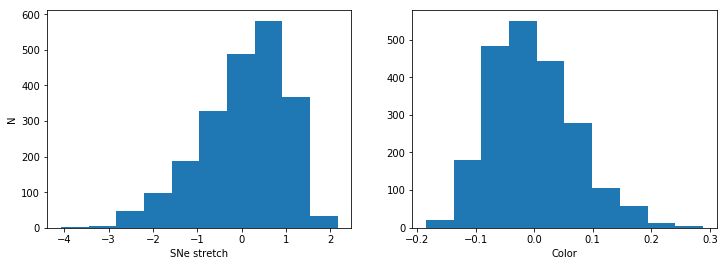

In [54]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(sntab.x1_in, cumulative=False)
plt.ylabel('N')
plt.xlabel('SNe stretch')

plt.subplot(122)
plt.hist(sntab.c_in, cumulative=False)
plt.xlabel(r'Color')
plt.show()

## Using the SN coordinates to look into the templates

In [55]:
import importlib

In [56]:
importlib.reload(dmu)

<module 'dm_utilities' from '/global/homes/b/bos0109/run2_diaproc/dm_utilities.py'>

In [57]:
i = np.random.randint(len(sntab))
print(i)
snra, sndec = sntab.snra_in.values[i], sntab.sndec_in.values[i]

1432


In [58]:
im = butler.get('deepCoadd', {'patch': '1,5', 'tract':4431, 'filter':'g' })

In [59]:
snra, sndec

(56.66160763476085, -31.79820121998721)

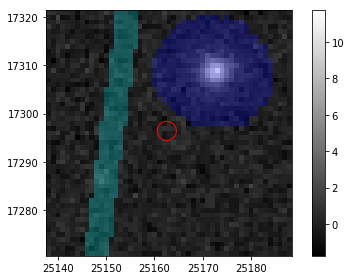

In [60]:
frame = 0
plt.figure(frame)

plt.subplot(221)
cutout = dmu.display_cutout_image(butler, snra, sndec, filter='g')

plt.subplot(222)
cutout = dmu.display_cutout_image(butler, snra, sndec, filter='r')

plt.subplot(223)
cutout = dmu.display_cutout_image(butler, snra, sndec, filter='i')

plt.subplot(224)
cutout = dmu.display_cutout_image(butler, snra, sndec, filter='z')

<Figure size 432x288 with 0 Axes>

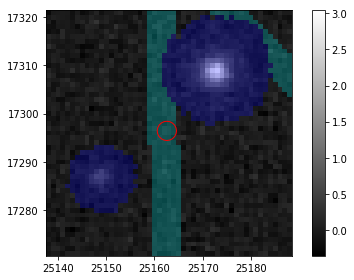

In [61]:
frame = 1
plt.figure(frame)
cutout = dmu.display_cutout_image(butler, snra, sndec)

## The DIA sources inspection

In [ ]:
diarepo2 = '/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/rerun/assoc_sha'

In [ ]:
print(diarepo)

In [ ]:
butlerdia = Butler(diarepo2)

In [ ]:
frame = 1
plt.figure(frame)
cutout = dmu.display_cutout_image(butlerdia, sntab.snra_in.values[3], sntab.sndec_in.values[3], backend='ipympl')

In [ ]:
diaMapper = butlerdia._getDefaultMapper()

In [56]:
diamapper = diaMapper(diarepo)

NameError: name 'diaMapper' is not defined

In [173]:
all_diadataset_types = diamapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_diadataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

In [174]:
print([dtst for dtst in shortlist if 'dia' in dtst] )

['dcrDiff_diaSrc', 'deepDiff_diaObject', 'deepDiff_diaSrc', 'deepDiff_forced_diaObject', 'deepDiff_forced_diaSrc']


In [175]:
butlerdia.datasetExists('deepDiff_diaSrc')

False

In [176]:
butlerdia.getKeys('deepDiff_diaSrc')

{'visit': int,
 'filter': str,
 'raftName': str,
 'detectorName': str,
 'detector': int}

In [177]:
#tpId = {'tract':4639, 'patch': '0,0'}

In [178]:
metadata = butlerdia.queryMetadata('deepDiff_diaSrc', ['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector'],
                                   dataId=tpId)

In [117]:
meta = pd.DataFrame(metadata, columns=['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector'])

In [118]:
meta.head()

,id,visit,filter,raftName,detectorName,detector
0,1,12469,y,R24,S01,109
1,2,12469,y,R24,S02,110
2,3,12469,y,R24,S10,111
3,4,12469,y,R24,S11,112
4,5,12469,y,R24,S12,113


In [119]:
meta = meta[meta['filter']!='u']
meta = meta[meta['filter']!='y']

In [123]:
path = '/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff/'
diffpath = 'v{}-f{}/{}/diaSrc_{}-{}-{}-{}-det{}.fits'

cats = []
for idx, vn, fna, raf, detN, det in metadata:
    if fna=='y' or fna=='u': continue
    
    dpath = os.path.join(path, diffpath.format(str(vn).zfill(8), fna, raf, 
                                               str(vn).zfill(8), fna,raf, detN, 
                                               str(det).zfill(3)))
    if os.path.exists(dpath):
        catalog = butlerdia.get('deepDiff_diaSrc', visit=vn, detector=det).asAstropy()
        if len(catalog) is not 0:
            catalog['visit_n'] = vn
            catalog['filter'] = fna
            catalog['raft'] = raf
            catalog['sensor'] = detN
            catalog['detector'] = det

            cats.append(catalog)

In [141]:
len(cats)

9587

In [124]:
ls /global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff/v00159481-fg/R02/

diaSrc_00159481-g-R02-S00-det009.fits  diffexp_00159481-g-R02-S00-det009.fits
diaSrc_00159481-g-R02-S01-det010.fits  diffexp_00159481-g-R02-S01-det010.fits
diaSrc_00159481-g-R02-S02-det011.fits  diffexp_00159481-g-R02-S02-det011.fits
diaSrc_00159481-g-R02-S10-det012.fits  diffexp_00159481-g-R02-S10-det012.fits
diaSrc_00159481-g-R02-S11-det013.fits  diffexp_00159481-g-R02-S11-det013.fits
diaSrc_00159481-g-R02-S12-det014.fits  diffexp_00159481-g-R02-S12-det014.fits
diaSrc_00159481-g-R02-S20-det015.fits  diffexp_00159481-g-R02-S20-det015.fits
diaSrc_00159481-g-R02-S21-det016.fits  diffexp_00159481-g-R02-S21-det016.fits
diaSrc_00159481-g-R02-S22-det017.fits  diffexp_00159481-g-R02-S22-det017.fits


In [125]:
from astropy.table import vstack

In [126]:
mastercat = vstack(cats)

In [134]:
mastercat.write('./mastercatalog_dia_srcs_rect.fits', format='fits')

In [151]:
#mastercat.write('./mastercatalog_dia_srcs_rect.csv', format='csv')

In [ ]:
#mastercat.write('./mastercatalog_dia_srcs_rect.h5', path='diaSrc_mastercat',format='hdf5')

In [135]:
butlerdia.getKeys('deepDiff_diaObject')

{'tract': int, 'patch': str}

In [184]:
tpId

{'tract': 4431, 'patch': '1,5'}

In [186]:
objs = butlerdia.get('deepDiff_diaObject', dataId=tpId).asAstropy()

In [137]:
len(objs)

518

In [138]:
objs.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'nobs',
 'base_PsfFlux_instFlux_Ndata_u',
 'base_PsfFlux_instFlux_Sigma_u',
 'base_PsfFlux_instFlux_MeanErr_u',
 'base_PsfFlux_instFlux_Mean_u',
 'base_PsfFlux_instFlux_Ndata_g',
 'base_PsfFlux_instFlux_Sigma_g',
 'base_PsfFlux_instFlux_MeanErr_g',
 'base_PsfFlux_instFlux_Mean_g',
 'base_PsfFlux_instFlux_Ndata_r',
 'base_PsfFlux_instFlux_Sigma_r',
 'base_PsfFlux_instFlux_MeanErr_r',
 'base_PsfFlux_instFlux_Mean_r',
 'base_PsfFlux_instFlux_Ndata_i',
 'base_PsfFlux_instFlux_Sigma_i',
 'base_PsfFlux_instFlux_MeanErr_i',
 'base_PsfFlux_instFlux_Mean_i',
 'base_PsfFlux_instFlux_Ndata_z',
 'base_PsfFlux_instFlux_Sigma_z',
 'base_PsfFlux_instFlux_MeanErr_z',
 'base_PsfFlux_instFlux_Mean_z',
 'base_PsfFlux_instFlux_Ndata_y',
 'base_PsfFlux_instFlux_Sigma_y',
 'base_PsfFlux_instFlux_MeanErr_y',
 'base_PsfFlux_instFlux_Mean_y']

In [157]:
mastercat.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'flags_negative',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_PeakCentroid_x',
 'base_PeakCentroid_y',
 'base_PeakCentroid_flag',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xErr',
 'base_SdssCentroid_yErr',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_flag_almostNoSecondDerivative',
 'base_SdssCentroid_flag_notAtMaximum',
 'base_SdssCentroid_flag_resetToPeak',
 'ip_diffim_NaiveDipoleCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 'base_GaussianFlux_flag_badCentroid',
 'base_NaiveCentroid_flag_badInitialCentroid',
 'base_PeakLikelihoodFlux_flag_badCentroid',
 'base_PsfFlux_flag_badCentroid',
 'base_SdssCentroid_flag_badInitialCentroid',
 'base_SdssShape_flag_badCentroid',
 '

In [156]:
mastercat[:10]

id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_PeakCentroid_x,base_PeakCentroid_y,base_PeakCentroid_flag,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,ip_diffim_NaiveDipoleCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PeakLikelihoodFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssCentroid_flag_badInitialCentroid,base_SdssShape_flag_badCentroid,slot_Centroid_flag,ip_diffim_NaiveDipoleCentroid_pos_flag,slot_Centroid_pos_flag,ip_diffim_NaiveDipoleCentroid_neg_flag,slot_Centroid_neg_flag,ip_diffim_NaiveDipoleCentroid_x,slot_Centroid_x,ip_diffim_NaiveDipoleCentroid_y,slot_Centroid_y,ip_diffim_NaiveDipoleCentroid_xErr,slot_Centroid_xErr,ip_diffim_NaiveDipoleCentroid_yErr,slot_Centroid_yErr,ip_diffim_NaiveDipoleCentroid_pos_x,slot_Centroid_pos_x,ip_diffim_NaiveDipoleCentroid_pos_y,slot_Centroid_pos_y,ip_diffim_NaiveDipoleCentroid_pos_xErr,slot_Centroid_pos_xErr,ip_diffim_NaiveDipoleCentroid_pos_yErr,slot_Centroid_pos_yErr,ip_diffim_NaiveDipoleCentroid_neg_x,slot_Centroid_neg_x,ip_diffim_NaiveDipoleCentroid_neg_y,slot_Centroid_neg_y,ip_diffim_NaiveDipoleCentroid_neg_xErr,slot_Centroid_neg_xErr,ip_diffim_NaiveDipoleCentroid_neg_yErr,slot_Centroid_neg_yErr,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape_xyErr,slot_Shape_xyErr,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_instFlux,slot_Shape_instFlux,base_SdssShape_instFluxErr,slot_Shape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,slot_Shape_psf_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,slot_Shape_psf_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,slot_Shape_psf_xy,base_SdssShape_instFlux_xx_Cov,slot_Shape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,slot_Shape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,slot_Shape_instFlux_xy_Cov,base_SdssShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,base_SdssShape_flag_unweightedBad,base_GaussianFlux_flag_badShape_unweightedBad,slot_Shape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_GaussianFlux_flag_badShape_unweighted,slot_Shape_flag_unweighted,base_SdssShape_flag_shift,base_GaussianFlux_flag_badShape_shift,slot_Shape_flag_shift,base_SdssShape_flag_maxIter,base_GaussianFlux_flag_badShape_maxIter,slot_Shape_flag_maxIter,base_SdssShape_flag_psf,base_GaussianFlux_flag_badShape_psf,slot_Shape_flag_psf,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,slot_ApFlux_instFlux,base_CircularApertureFlux_12_0_instFluxErr,slot_ApFlux_instFluxErr,base_CircularApertureFlux_12_0_flag,slot_

In [188]:
butlerdia.datasetExists('deepDiff_diaObject', dataId=tpId )

True

In [190]:
butlerdia.getKeys('deepDiff_diaObject')

{'tract': int, 'patch': str}

In [ ]:
pwd

In [79]:
sn_truth_t = pd.read_csv('catalogs+tables/SN_Truth_table.csv')

In [80]:
sn_truth_t['snid_in'] = sn_truth_t.snid_in.astype(str)

In [81]:
sn_truth_t['snid_in_cat'] = sn_truth_t.snid_in.astype('category')

In [82]:
sn_truth_t = sn_truth_t.astype({'snid_in': 'str'})

In [83]:
sntab['snid_in_cat'] = sntab.snid_in.astype('category')

In [84]:
sntab = sntab.astype({'snid_in': 'str'})

In [85]:
sn_truth_t.astype({'snid_in': 'str'}).dtypes

index                  int64
fieldID                int64
descDitheredRA       float64
descDitheredDec      float64
expMJD               float64
filter                object
fiveSigmaDepth       float64
fiveSigmaDepth.1     float64
rotSkyPos            float64
rotTelPos            float64
FWHMeff              float64
obsHistID              int64
mag                  float64
snid_in               object
chip                  object
xpixel               float64
ypixel               float64
snid_in_cat         category
dtype: object

In [86]:
len(sn_truth_t)

1809

In [87]:
len(mastercat)

6127

In [88]:
sn_truth_t.columns

Index(['index', 'fieldID', 'descDitheredRA', 'descDitheredDec', 'expMJD',
       'filter', 'fiveSigmaDepth', 'fiveSigmaDepth.1', 'rotSkyPos',
       'rotTelPos', 'FWHMeff', 'obsHistID', 'mag', 'snid_in', 'chip', 'xpixel',
       'ypixel', 'snid_in_cat'],
      dtype='object')

In [89]:
sntab.columns

Index(['htmid_level_6', 'galaxy_id', 'c_in', 'mB', 't0_in', 'x0_in', 'x1_in',
       'z_in', 'snid_in', 'snra_in', 'sndec_in', 'snid_in_cat'],
      dtype='object')

## Matching coordinates of Truth vs diaObject

In [90]:
from astropy.coordinates import SkyCoord

In [91]:
tru_c = SkyCoord(sntab.snra_in*u.deg, sntab.sndec_in*u.deg)

In [92]:
#objs['coord_ra']

In [93]:
dia_c = SkyCoord(objs['coord_ra'], objs['coord_dec'])

In [94]:
objs

id,coord_ra,coord_dec,parent,nobs,base_PsfFlux_instFlux_Sigma_u,base_PsfFlux_instFlux_Ndata_u,base_PsfFlux_instFlux_Mean_u,base_PsfFlux_instFlux_MeanErr_u,base_PsfFlux_instFlux_Sigma_g,base_PsfFlux_instFlux_Ndata_g,base_PsfFlux_instFlux_Mean_g,base_PsfFlux_instFlux_MeanErr_g,base_PsfFlux_instFlux_Sigma_r,base_PsfFlux_instFlux_Ndata_r,base_PsfFlux_instFlux_Mean_r,base_PsfFlux_instFlux_MeanErr_r,base_PsfFlux_instFlux_Sigma_i,base_PsfFlux_instFlux_Ndata_i,base_PsfFlux_instFlux_Mean_i,base_PsfFlux_instFlux_MeanErr_i,base_PsfFlux_instFlux_Sigma_z,base_PsfFlux_instFlux_Ndata_z,base_PsfFlux_instFlux_Mean_z,base_PsfFlux_instFlux_MeanErr_z,base_PsfFlux_instFlux_Sigma_y,base_PsfFlux_instFlux_Ndata_y,base_PsfFlux_instFlux_Mean_y,base_PsfFlux_instFlux_MeanErr_y
,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,int32,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64
20402537765011457,0.9978603682712568,-0.5429574734213227,0,12,nan,0,nan,nan,0.0,1,39.40258169766635,0.0,nan,8,nan,nan,nan,2,nan,nan,nan,0,nan,nan,nan,0,nan,nan
20402537765011458,0.9983347428593629,-0.544236352279477,0,5,nan,0,nan,nan,nan,0,nan,nan,nan,4,nan,nan,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan
20402537765011459,0.9975613828504386,-0.542439195416928,0,28,nan,0,nan,nan,nan,3,nan,nan,nan,9,nan,nan,nan,11,nan,nan,nan,5,nan,nan,nan,0,nan,nan
20402537765011460,0.9980463913904404,-0.5437032405518898,0,2,nan,0,nan,nan,0.0,1,11.262422506240389,0.0,0.0,1,23.176506511667338,0.0,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan
20402537765011461,0.9981642610697316,-0.5441223322631592,0,6,nan,0,nan,nan,0.0,1,8.139694700288107,0.0,nan,4,nan,nan,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan
20402537765011462,0.9971780450457584,-0.5423322508701265,0,31,nan,0,nan,nan,nan,3,nan,nan,3.7156771820862553,8,41.07238034606523,1.3136902660766565,nan,17,nan,nan,nan,3,nan,nan,nan,0,nan,nan
20402537765011463,0.9971037094908815,-0.5421563136492299,0,1,nan,0,nan,nan,0.0,1,11.371210226268358,0.0,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan
20402537765011464,0.9973773774265411,-0.5429106658671341,0,1,nan,0,nan,nan,0.0,1,16.248638204688554,0.0,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan,nan,0,nan,nan


In [95]:
merged = pd.merge(left=sn_truth_t, right=sntab, how='left', on='snid_in_cat', suffixes=('_tab', '_par'))

In [96]:
merged

,index,fieldID,descDitheredRA,descDitheredDec,expMJD,filter,fiveSigmaDepth,fiveSigmaDepth.1,rotSkyPos,rotTelPos,...,galaxy_id,c_in,mB,t0_in,x0_in,x1_in,z_in,snid_in_par,snra_in,sndec_in
0,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
np.sum(merged['x0_in'].notnull())

0

In [98]:
mastercat.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'flags_negative',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_PeakCentroid_x',
 'base_PeakCentroid_y',
 'base_PeakCentroid_flag',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xErr',
 'base_SdssCentroid_yErr',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_flag_almostNoSecondDerivative',
 'base_SdssCentroid_flag_notAtMaximum',
 'base_SdssCentroid_flag_resetToPeak',
 'ip_diffim_NaiveDipoleCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 'base_GaussianFlux_flag_badCentroid',
 'base_NaiveCentroid_flag_badInitialCentroid',
 'base_PeakLikelihoodFlux_flag_badCentroid',
 'base_PsfFlux_flag_badCentroid',
 'base_SdssCentroid_flag_badInitialCentroid',
 'base_SdssShape_flag_badCentroid',
 '